<style>
table, th, td {
    border: 1px solid black;
}
</style>

<table style="width:100%" >

  <tr >
    <th align="center">Tensorflow</th>
    <th align="center">python</th>
    <th align="center">google</th>
    <th align="center">udacity</th>
  </tr>

  <tr>
    <td>
      <img src="https://upload.wikimedia.org/wikipedia/commons/a/a4/TensorFlowLogo.png" height="200" width="200" />
    </td>
    <td>
      <img src="http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png" height="200" width="200" />
    </td>
    <td>
      <img src="https://www.blog.google/static/blog/images/google-200x200.7714256da16f.png" height="200" width="200" />
    </td>
    <td>
      <img src="https://d125fmws0bore1.cloudfront.net/assets/udacity_share-317a7f82552763598a5c91e1550b7cd83663ce02d6d475d703e25a873cd3b574.png" height="200" width="200" />
    </td>
  </tr>
</table>

# Deep Learning - my Notes.
## Arturo Alatriste Trujillo

# Deep Learning
## Assignment 2

Previously in 1_notmnist.ipynb, we created a pickle with formatted datasets for training, development and testing on the notMNIST [dataset](http://yaroslavvb.blogspot.mx/2011/09/notmnist-dataset.html)


The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [23]:
%pwd

'C:\\Users\\a.alatriste.trujillo\\dl_udacity'

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
from six.moves  import cPickle as pickle
from six.moves  import range

import numpy      as np
import tensorflow as tf


First reload the data we generated in 1_notmnist.ipynb.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save          = pickle.load(f)
  train_dataset = save[ 'train_dataset' ]
  train_labels  = save[ 'train_labels'  ]
  valid_dataset = save[ 'valid_dataset' ]
  valid_labels  = save[ 'valid_labels'  ]
  test_dataset  = save[ 'test_dataset'  ]
  test_labels   = save[ 'test_labels'   ]

  del save  # hint to help gc free up memory
  print( 'Training set  :', train_dataset.shape, train_labels.shape )
  print( 'Validation set:', valid_dataset.shape, valid_labels.shape )
  print( 'Test set      :', test_dataset.shape , test_labels.shape  )

Training set  : (200000, 28, 28) (200000,)
Validation set: (10000, 28, 28) (10000,)
Test set      : (10000, 28, 28) (10000,)


In [4]:
print( type( train_dataset[ 0 ] ) )
print( type( train_labels [ 0 ] ) )

<class 'numpy.ndarray'>
<class 'numpy.int32'>


Reformat into a shape that's more adapted to the models we're going to train:

* data as a flat matrix,
* labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels  = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat( train_dataset, train_labels )
valid_dataset, valid_labels = reformat( valid_dataset, valid_labels )
test_dataset , test_labels  = reformat( test_dataset, test_labels   )

print( 'Training set'  , train_dataset.shape, train_labels.shape )
print( 'Validation set', valid_dataset.shape, valid_labels.shape )
print( 'Test set'      , test_dataset.shape , test_labels.shape  )

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.
TensorFlow works like this:

* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

   ```with graph.as_default():
    ...```


* Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

   ```with tf.Session(graph=graph) as session:
    ...```
    
Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [6]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant( train_dataset[:train_subset, :] )
  tf_train_labels  = tf.constant( train_labels[:train_subset]     )
  tf_valid_dataset = tf.constant( valid_dataset                   )
  tf_test_dataset  = tf.constant( test_dataset                    )
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

#### first run

Let's run this computation and iterate:

In [7]:
num_steps = 801

def accuracy(predictions, labels):
  return ( 100.0 * np.sum( np.argmax(predictions, 1 ) == np.argmax(labels, 1) )
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.110365
Training accuracy: 8.0%
Validation accuracy: 11.3%
Loss at step 100: 2.284174
Training accuracy: 72.2%
Validation accuracy: 69.8%
Loss at step 200: 1.829812
Training accuracy: 75.4%
Validation accuracy: 72.4%
Loss at step 300: 1.594261
Training accuracy: 76.7%
Validation accuracy: 73.2%
Loss at step 400: 1.437207
Training accuracy: 77.5%
Validation accuracy: 73.8%
Loss at step 500: 1.320337
Training accuracy: 78.0%
Validation accuracy: 74.2%
Loss at step 600: 1.228344
Training accuracy: 78.6%
Validation accuracy: 74.4%
Loss at step 700: 1.153268
Training accuracy: 79.2%
Validation accuracy: 74.5%
Loss at step 800: 1.090254
Training accuracy: 79.7%
Validation accuracy: 74.8%
Test accuracy: 82.7%


Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of 

```session.run()```

In [10]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder( tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant( valid_dataset )
  tf_test_dataset  = tf.constant( test_dataset  )
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases  = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss   = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [11]:
print( 'batch_size: {0}'.format( batch_size ) )
print( 'train_labels.shape[0]: {:,} '.format( train_labels.shape[0] ) )
print(  '(train_labels.shape[0] - batch_size): {:,} '.format( (train_labels.shape[0] - batch_size) ) )

batch_size: 128
train_labels.shape[0]: 200,000 
(train_labels.shape[0] - batch_size): 199,872 


Let's run it:

In [12]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #print( 'step: {0}, offset: {1}'.format( step, offset ) )
    
    
    # Generate a minibatch.
    batch_data   = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.320940
Minibatch accuracy: 7.8%
Validation accuracy: 9.0%
Minibatch loss at step 500: 1.457492
Minibatch accuracy: 77.3%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.510089
Minibatch accuracy: 78.1%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 0.828183
Minibatch accuracy: 80.5%
Validation accuracy: 77.0%
Minibatch loss at step 2000: 0.783964
Minibatch accuracy: 85.9%
Validation accuracy: 77.5%
Minibatch loss at step 2500: 1.074346
Minibatch accuracy: 72.7%
Validation accuracy: 77.8%
Minibatch loss at step 3000: 0.937889
Minibatch accuracy: 80.5%
Validation accuracy: 78.8%
Test accuracy: 86.5%


---
<hr>

### Problem
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. This model should improve your validation / test accuracy.

###  the graph visualization

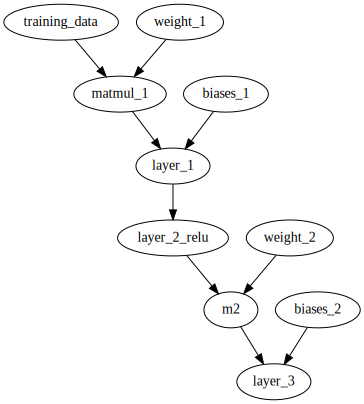

In [22]:
from graphviz import Digraph

dot = Digraph(comment='The Round Table')

dot.node('X'       , 'training_data')
dot.node('w1'      , 'weight_1')
dot.node('m1'      , 'matmul_1')

dot.node('biases_1', 'biases_1')
dot.node('layer_1' , 'layer_1')


dot.edge('X'       ,  'm1'    )
dot.edge('w1'      , 'm1'    )
dot.edge('m1'      , 'layer_1')
dot.edge('biases_1', 'layer_1')
#dot.edge('biases_1', 'layer1', constraint='true')

# layer 2
dot.node('w2'      , 'weight_2')
dot.node('m2'      , 'm2')
dot.node('biases_2', 'biases_2')
dot.node('layer_2' , 'layer_2_relu')

dot.edge('layer_1' ,  'layer_2'    )
dot.edge('layer_2' ,  'm2'    )

dot.edge('w2'      , 'm2'    )
dot.edge('m2'      , 'layer_3')
dot.edge('biases_2', 'layer_3')

dot.node('layer_3' , 'layer_3')

# display image
dot

#### create graph

In [20]:
#SGD with relu
batch_size = 128
relu_count = 1024 #hidden nodes count

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  

    # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, relu_count]))
  biases_1 = tf.Variable(tf.zeros([relu_count]))
    
  # send relu to final nn layer
  weights_2 = tf.Variable(
    tf.truncated_normal([relu_count, num_labels]))

  biases_2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation. (#layer_1 -> layer_2(relu) -> layer_3)
  logits = tf.matmul( tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1), weights_2) + biases_2

'''
  logits = tf.matmul( 
                      tf.nn.relu(
                                  tf.matmul(tf_train_dataset, weights_1) + biases_1
                                ), 
                      weights_2) 
         + biases_2
'''


  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits( labels = tf_train_labels, logits = logits ))



  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul( tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(
        tf.matmul( tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

#### run sesion

In [21]:
num_steps = 5000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 367.766266
Minibatch accuracy: 5.5%
Validation accuracy: 25.7%
Minibatch loss at step 500: 20.438694
Minibatch accuracy: 75.8%
Validation accuracy: 79.0%
Minibatch loss at step 1000: 12.204794
Minibatch accuracy: 78.9%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 6.139073
Minibatch accuracy: 85.2%
Validation accuracy: 79.9%
Minibatch loss at step 2000: 3.440598
Minibatch accuracy: 89.1%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 2.014385
Minibatch accuracy: 87.5%
Validation accuracy: 81.3%
Minibatch loss at step 3000: 3.027340
Minibatch accuracy: 78.9%
Validation accuracy: 82.2%
Minibatch loss at step 3500: 6.011634
Minibatch accuracy: 80.5%
Validation accuracy: 82.4%
Minibatch loss at step 4000: 4.155736
Minibatch accuracy: 82.0%
Validation accuracy: 80.2%
Minibatch loss at step 4500: 4.657096
Minibatch accuracy: 85.9%
Validation accuracy: 81.3%
Test 

#### references

Deep Learning by Google
* https://www.udacity.com/course/deep-learning--ud730

Github repository used for the course
* https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/udacity

not MNIST dataset
* http://yaroslavvb.blogspot.mx/2011/09/notmnist-dataset.html
* http://yaroslavvb.com/upload/notMNIST/
 
THE MNIST DATABASE
* http://yann.lecun.com/exdb/mnist/

Plotting multiple images
* http://nbviewer.jupyter.org/gist/minrk/7076095

other students
* https://github.com/sdurgi17/udacity-deep-learning/blob/master/

* https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/